# Trust Region Policy Optimization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize
from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torch.distributions import MultivariateNormal

In [3]:
from utils import *
from buffer import BasicBuffer
from model import PolicyNetwork, ValueNetwork
from running_state import ZFilter
from trpo import trpo_step

In [4]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [5]:
plt.style.use('ggplot')

## Set Configs

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
torch.utils.backcompat.broadcast_warning.enabled = True
torch.utils.backcompat.keepdim_warning.enabled = True

torch.set_default_tensor_type('torch.DoubleTensor')

In [8]:
GAMMA = 0.995
TAU = 0.97
PRINT_EVERY = 1

DECAY_RATE = 1e-3
MAX_KL = 1e-2
DAMPING = 1e-1
BATCH_SIZE = 15000

## Set Environment

In [9]:
ENV_NAME = 'BipedalWalker-v2'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [10]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
# env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(24,)
Action space Box(4,)


## Define [TRPO](https://arxiv.org/pdf/1502.05477.pdf) Agent

In [11]:
class TRPOAgent():
    """The Agent that will interacts with and learns from the environment."""
    
    def __init__(self, env, seed):
        """Initialize an Agent object."""
        
        self.env = env
    
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
                
        self.gamma = GAMMA
        self.tau = TAU
        self.decay_rate = DECAY_RATE
        self.max_kl = MAX_KL
        self.damping = DAMPING
        
        self.policy = PolicyNetwork(self.state_size, self.action_size, seed).to(device)
        self.value = ValueNetwork(self.state_size, seed).to(device)
        
        # set buffer
        self.buffer = BasicBuffer(seed=90)
        
        # set Zfilter
        self.running_state = ZFilter((self.state_size,), clip=5)
        self.running_reward = ZFilter((1,), demean=False, clip=10)
        
    def memorize(self, state, action, reward, next_state, mask):
        
        self.buffer.add(state, np.array([action]), reward, next_state, mask)
        
    def act(self, state):
        
        state = torch.from_numpy(state).unsqueeze(0)
        action_mean, _, action_std = self.policy(Variable(state))
        action = torch.normal(action_mean, action_std)
        
        return action.data[0].numpy()
    
    def learn(self):
    
        experiences = self.buffer.sample()
        self.update_params(experiences)
    
    def update_params(self, experiences):
        
        states = torch.Tensor(experiences.state)
        actions = torch.Tensor(np.concatenate(experiences.action, 0))
        rewards = torch.Tensor(experiences.reward)
        masks = torch.Tensor(experiences.mask)
        
        returns = torch.Tensor(actions.size(0), 1)
        deltas = torch.Tensor(actions.size(0), 1)
        advantages = torch.Tensor(actions.size(0), 1)
        
        old_return = 0
        old_value = 0
        old_advantage = 0
    
        values = self.value(Variable(states))
    
        for i in reversed(range(rewards.size(0))):
            
            returns[i] = rewards[i] + self.gamma * old_return * masks[i]
            deltas[i] = rewards[i] + self.gamma * old_value * masks[i] - values.data[i]
            advantages[i] = deltas[i] + self.gamma * self.tau * old_advantage * masks[i]
            
            old_return = returns[i, 0]
            old_value = values.data[i, 0]
            old_advantage = advantages[i, 0]
            
        targets = Variable(returns)

        # original code uses the same LBFGS to optimize the value loss
        def get_value_loss(flat_params):

            set_flat_params_to(self.value, torch.Tensor(flat_params))
            for param in self.value.parameters():
                if param.grad is not None:
                    param.grad.data.fill_(0)

            values_ = self.value(Variable(states))

            value_loss = (values_ - targets).pow(2).mean()

            # weight decay
            for param in self.value.parameters():
                value_loss += param.pow(2).sum() * self.decay_rate
            value_loss.backward()

            return (value_loss.data.double().numpy(), get_flat_grad_from(self.value).data.double().numpy())
        
        flat_params, _, opt_info = scipy.optimize.fmin_l_bfgs_b(get_value_loss, get_flat_params_from(self.value).double().numpy(), maxiter=25)
        set_flat_params_to(self.value, torch.Tensor(flat_params))
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
        action_means, action_log_stds, action_stds = self.policy(Variable(states))
        fixed_log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds).data.clone()
        
        def get_policy_loss(volatile=False):

            if volatile:
                with torch.no_grad():
                    action_means, action_log_stds, action_stds = self.policy(Variable(states))
            else:
                action_means, action_log_stds, action_stds = self.policy(Variable(states))

            log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds)
            action_loss = -Variable(advantages) * torch.exp(log_prob - Variable(fixed_log_prob))

            return action_loss.mean()

        def get_kl():

            mean, log_std, std = self.policy(states)

            mean_old = Variable(mean.data)
            log_std_old = Variable(log_std.data)
            std_old = Variable(std.data)

            kl = log_std - log_std_old + (std_old.pow(2) + (mean_old - mean).pow(2)) / (2.0 * std.pow(2)) - 0.5
            return kl.sum(1, keepdim=True)
        
        policy_loss = trpo_step(self.policy, get_policy_loss, get_kl, self.max_kl, self.damping)
        
    def save(self, policy_path, value_path):
        
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        torch.save(self.policy.state_dict(), policy_path); torch.save(self.value.state_dict(), value_path)
    
    def watch(self, num_episodes):
        
        for i_episode in range(1, num_episodes+1):
    
            state = env.reset()
            state = agent.running_state(state)
            
            reward_sum = 0
            
            for time_step in range(10000):

                env.render() # render the screen

                action = self.act(state) # select an action
                next_state, reward, done, _ = env.step(action)
                next_state = agent.running_state(next_state)

                state = next_state
                reward_sum += reward
                if done:
                    break

            print(f'\rEpisode: {i_episode}, Last Reward: {reward_sum:.2f}')

        env.close()

In [12]:
agent = TRPOAgent(env, seed=90)

## Train The Agent

In [13]:
def train_agent(num_episodes=10000):
    
    scores = []
    scores_window = deque(maxlen=PRINT_EVERY)
    
    for i_episode in range(1, num_episodes+1):
        
        agent.buffer.clear_memory()
        
        num_steps = 0
        num_episodes = 0
        reward_batch = 0
        
        while num_steps < BATCH_SIZE:

            state = env.reset()
            state = agent.running_state(state)

            reward_sum = 0

            for time_step in range(10000):
                
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)            
                next_state = agent.running_state(next_state)

                mask = 0 if done else 1
                agent.memorize(state, action, reward, next_state, mask)
                
                state = next_state
                reward_sum += reward
                if done:
                    break

            num_steps += (time_step-1)
            num_episodes += 1
            reward_batch += reward_sum

        reward_batch /= num_episodes
        
        scores_window.append(reward_batch)
        scores.append(reward_batch)
        
        agent.learn()
        
        if i_episode % PRINT_EVERY == 0:
            print(f'Episode {i_episode}, Last Reward: {reward_sum:.2f}, Average Score: {reward_batch:.2f}')
            
        if np.mean(scores_window) >= 250.0:
            print(f'\nEnvironment solved in {i_episode:d} episodes!, Last Reward: {reward_sum:.2f}, Average Score: {reward_batch:.2f}')
            agent.save(f'./agents/POLICY_{ENV_NAME}.pth', f'./agents/VALUE_{ENV_NAME}.pth')
            break
    
    print('Training completed.')
    
    return scores

In [14]:
scores = train_agent(num_episodes=10000)

Episode 1, Last Reward: -682.15, Average Score: -310.92
Episode 2, Last Reward: -690.28, Average Score: -256.27
Episode 3, Last Reward: -671.53, Average Score: -485.70
Episode 4, Last Reward: -699.88, Average Score: -686.73
Episode 5, Last Reward: -660.78, Average Score: -232.17
Episode 6, Last Reward: -643.76, Average Score: -476.11
Episode 7, Last Reward: -660.67, Average Score: -474.21
Episode 8, Last Reward: -610.60, Average Score: -317.37
Episode 9, Last Reward: -630.52, Average Score: -639.72
Episode 10, Last Reward: -629.43, Average Score: -615.45
Episode 11, Last Reward: -558.61, Average Score: -586.89
Episode 12, Last Reward: -529.43, Average Score: -527.46
Episode 13, Last Reward: -515.11, Average Score: -492.04
Episode 14, Last Reward: -373.72, Average Score: -382.51
Episode 15, Last Reward: -346.01, Average Score: -334.36
Episode 16, Last Reward: -263.45, Average Score: -273.58
Episode 17, Last Reward: -213.55, Average Score: -197.47
Episode 18, Last Reward: -156.77, Averag

Episode 149, Last Reward: 247.07, Average Score: 245.01
Episode 150, Last Reward: 246.21, Average Score: 243.01
Episode 151, Last Reward: 247.52, Average Score: 201.19
Episode 152, Last Reward: 245.77, Average Score: 193.32
Episode 153, Last Reward: 243.87, Average Score: 242.36
Episode 154, Last Reward: 250.56, Average Score: 246.31
Episode 155, Last Reward: 239.20, Average Score: 225.75
Episode 156, Last Reward: 241.06, Average Score: 229.29
Episode 157, Last Reward: 247.38, Average Score: 217.26
Episode 158, Last Reward: 241.31, Average Score: 212.18
Episode 159, Last Reward: 238.48, Average Score: 246.99
Episode 160, Last Reward: 251.24, Average Score: 229.58
Episode 161, Last Reward: 242.33, Average Score: 246.95
Episode 162, Last Reward: 250.39, Average Score: 219.92
Episode 163, Last Reward: 244.33, Average Score: 249.21
Episode 164, Last Reward: 59.83, Average Score: 230.42
Episode 165, Last Reward: 249.02, Average Score: 251.08

Environment solved in 165 episodes!, Last Reward

## Evaluate The Agent

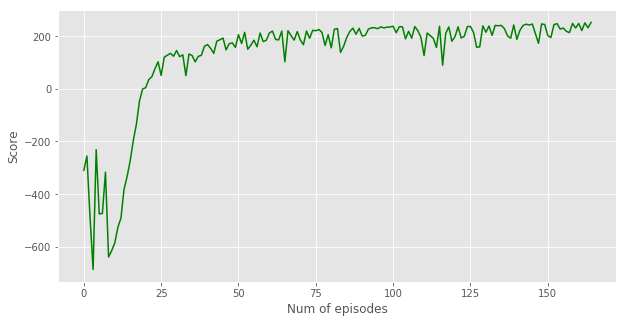

In [15]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_trpo_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [16]:
agent.policy.load_state_dict(torch.load(f'./agents/POLICY_{ENV_NAME}.pth'));

In [17]:
agent.watch(num_episodes=10)

Episode: 1, Last Reward: 251.27
Episode: 2, Last Reward: 255.40
Episode: 3, Last Reward: 239.01
Episode: 4, Last Reward: 250.43
Episode: 5, Last Reward: 248.15
Episode: 6, Last Reward: 249.68
Episode: 7, Last Reward: 244.15
Episode: 8, Last Reward: 249.45
Episode: 9, Last Reward: 249.29
Episode: 10, Last Reward: 246.73


---